### Importando Bbibliotecas

In [55]:
# pipenv install scikit-learn scipy pandas matplotlib seaborn ipykernel pingouin fastapi pydantic streamlit uvicorn requests

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

### Carregar Data Frame - Task 01

In [57]:
df_receita = pd.read_csv(r'.\datasets\sales_data.csv')

### EDA

In [58]:
df_receita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tempo_de_experiencia  100 non-null    int64  
 1   numero_de_vendas      100 non-null    int64  
 2   fator_sazonal         100 non-null    int64  
 3   receita_em_reais      100 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 3.3 KB


In [59]:
df_receita.head(10)

,tempo_de_experiencia,numero_de_vendas,fator_sazonal,receita_em_reais
0,36,21,5,2639.886941
1,74,44,10,4707.322227
2,38,44,4,5910.035131
3,52,62,6,6130.742546
4,97,56,2,7516.457681
5,67,70,10,1247.882324
6,119,69,2,3485.606208
7,66,62,2,2773.987427
8,68,96,3,4177.919578
9,106,42,2,4719.691069


In [60]:
df_receita.describe()

,tempo_de_experiencia,numero_de_vendas,fator_sazonal,receita_em_reais
count,100.000000,100.000000,100.000000,100.000000
mean,64.490000,54.490000,5.820000,5112.941924
std,32.397935,25.307201,2.836914,2544.731052
min,1.000000,10.000000,1.000000,1133.363948
25%,38.750000,37.500000,4.000000,2800.660516
50%,64.500000,52.500000,5.000000,4953.770034
75%,93.000000,70.500000,8.000000,7079.500163
max,119.000000,100.000000,10.000000,9941.016458


In [61]:
df_receita.isna().sum()

tempo_de_experiencia    0
numero_de_vendas        0
fator_sazonal           0
receita_em_reais        0
dtype: int64

<Axes: ylabel='tempo_de_experiencia'>

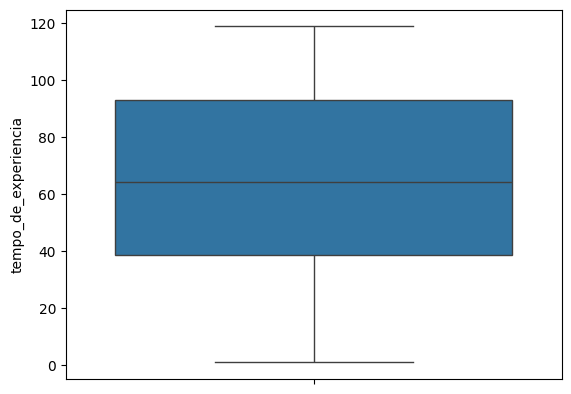

In [62]:
sns.boxplot(data=df_receita.tempo_de_experiencia)

<Axes: ylabel='numero_de_vendas'>

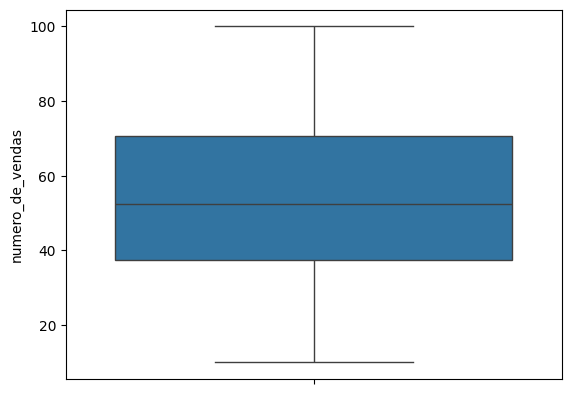

In [63]:
sns.boxplot(data=df_receita.numero_de_vendas)

<Axes: ylabel='fator_sazonal'>

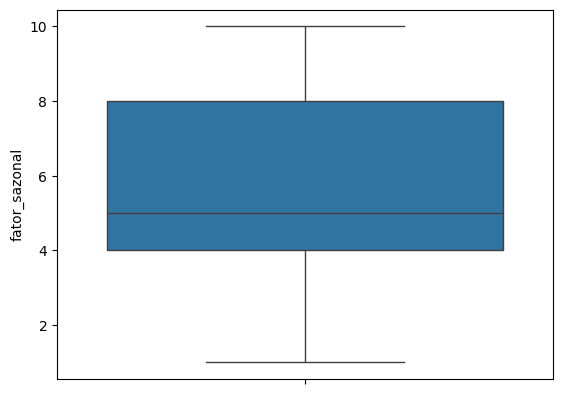

In [64]:
sns.boxplot(data=df_receita.fator_sazonal)

<Axes: ylabel='receita_em_reais'>

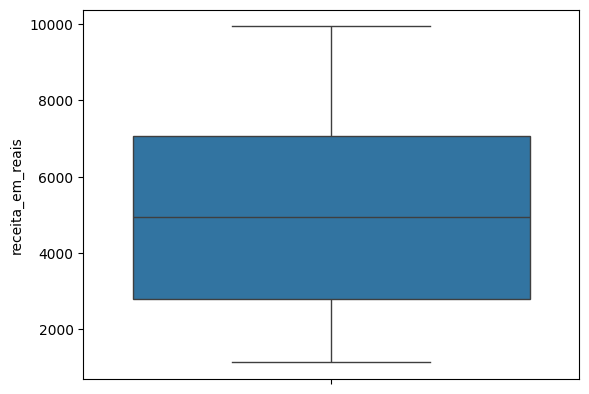

In [65]:
sns.boxplot(data=df_receita.receita_em_reais)

Não possuimos dados nulos e nem outliers no Data Frame

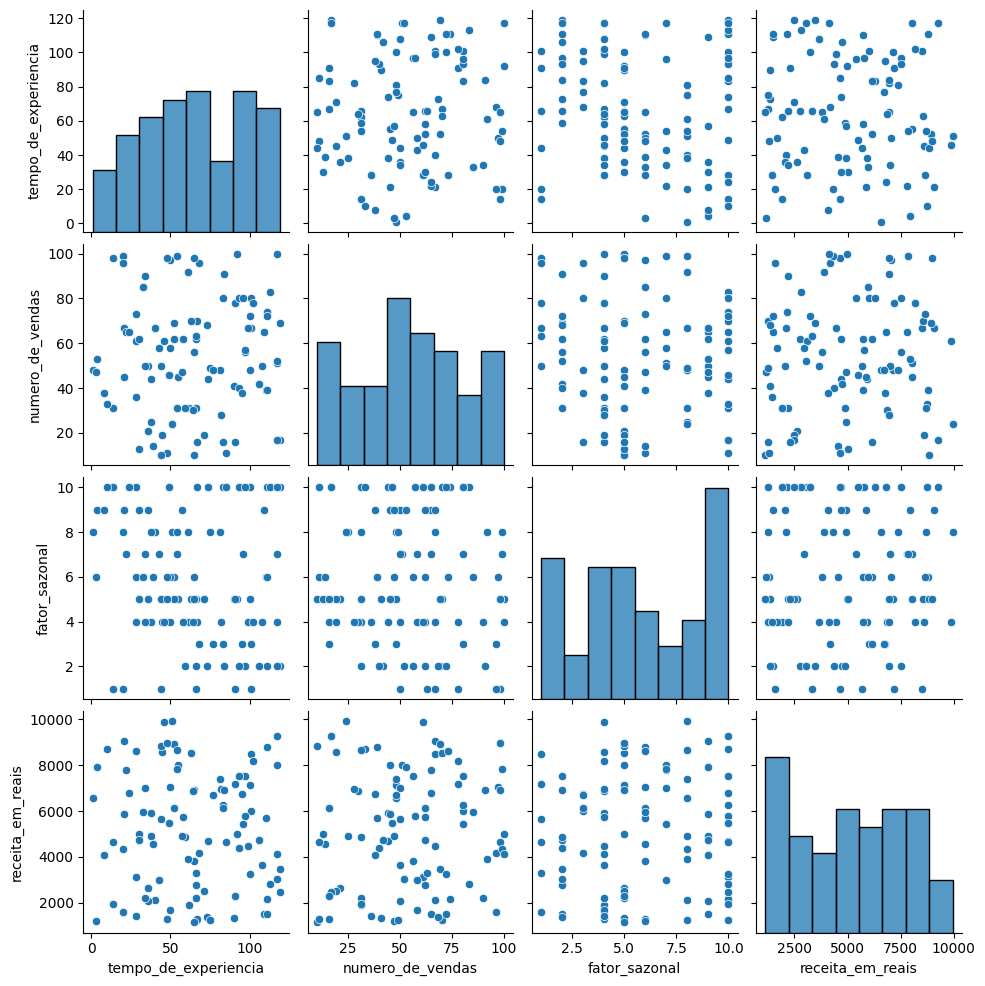

In [66]:
sns.pairplot(data=df_receita)

Verifica-se não temos um padrão no cruzamento de nenhuma das variaveis

<Axes: >

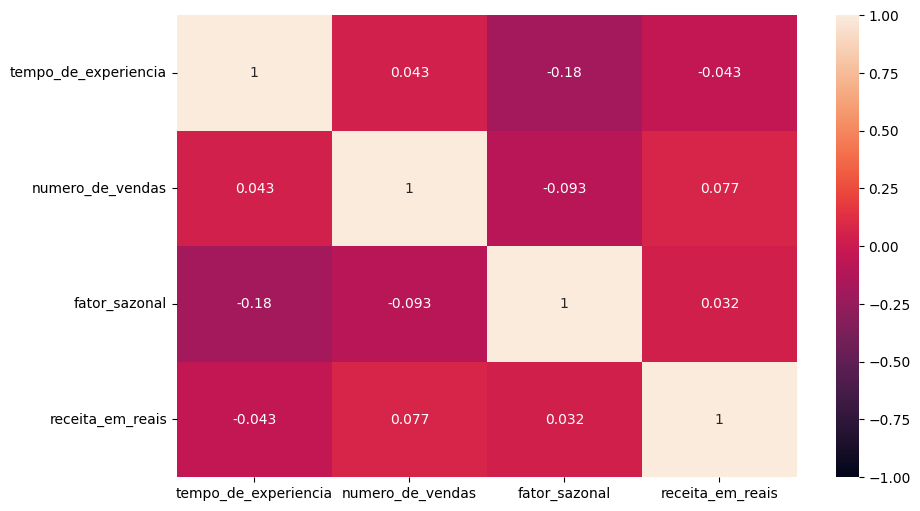

In [67]:
plt.figure(figsize=(10,6))
sns.heatmap(df_receita.corr(), vmin = -1, vmax=1, annot=True)

Nenhum variavel possui uma correlação de valor relevante com outra variavel

In [68]:
# Bucketing de tempo_de_experiência 
df_receita_bucketing = df_receita.copy()
bins_time_experience = [0,10,20,30,40,50,60,70,80,90,100,110,120,130]
labels_time_experience = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100-109','110-119','120-129']
df_receita_bucketing['escala_tempo_exp'] = pd.cut(x=df_receita.tempo_de_experiencia, bins= bins_time_experience, labels=labels_time_experience, include_lowest=True)

In [69]:
df_receita_bucketing.head(10)

,tempo_de_experiencia,numero_de_vendas,fator_sazonal,receita_em_reais,escala_tempo_exp
0,36,21,5,2639.886941,30-39
1,74,44,10,4707.322227,70-79
2,38,44,4,5910.035131,30-39
3,52,62,6,6130.742546,50-59
4,97,56,2,7516.457681,90-99
5,67,70,10,1247.882324,60-69
6,119,69,2,3485.606208,110-119
7,66,62,2,2773.987427,60-69
8,68,96,3,4177.919578,60-69
9,106,42,2,4719.691069,100-109


<Axes: xlabel='escala_tempo_exp', ylabel='receita_em_reais'>

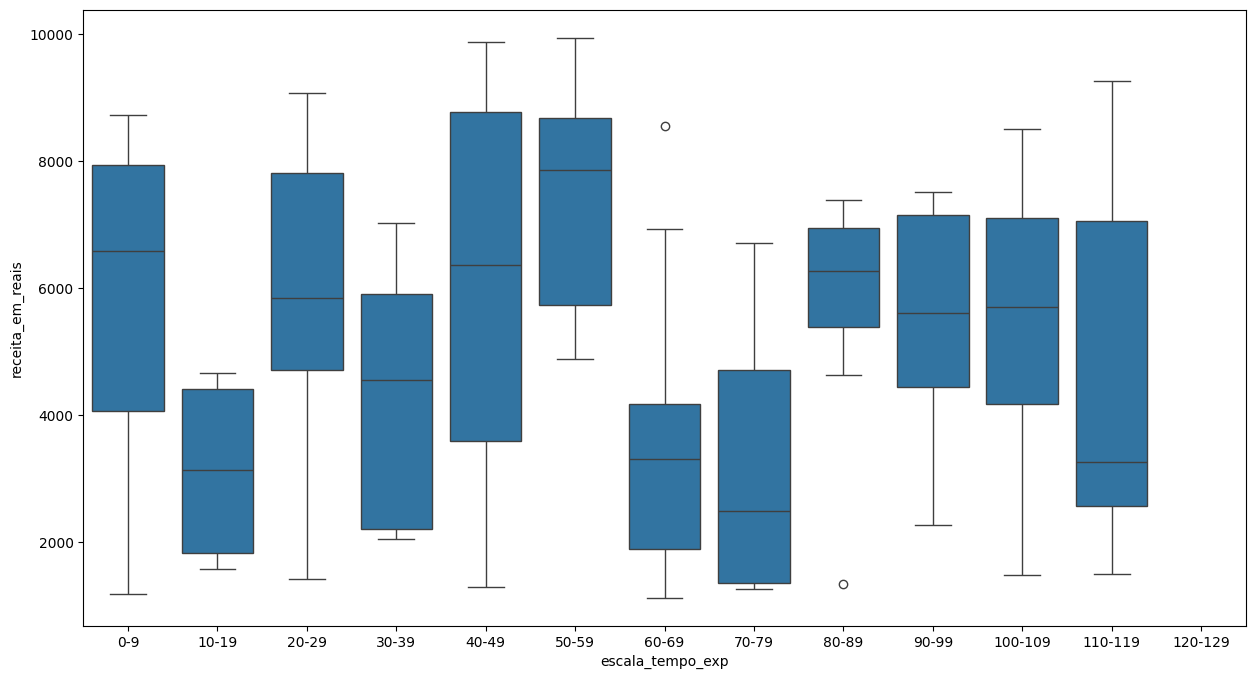

In [70]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df_receita_bucketing, x='escala_tempo_exp', y='receita_em_reais')

Verificasse que não temos um padrão entre a distribuição da variavel escala_tempo_exp e receita_em_reais

### Treinamento Modelo Linear


In [71]:
# Dividindo conjuntos
X = df_receita.drop(columns=['receita_em_reais'],axis=1)
y = df_receita.receita_em_reais

In [72]:
# Split dos dados usando Kfold com 5 pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [73]:
# Colunas numericas

colunas_numericas = ['tempo_de_experiencia','numero_de_vendas','fator_sazonal']

# Tranformer numerico
transformer_numerico = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#Preprocessor numerico
preprocessor = ColumnTransformer(transformers=[
    ('num', transformer_numerico, colunas_numericas)
])

# Modelo Linear
model_reg_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Armazenar RMSE Treino e teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar R2 score test
r2score_fold_test = []

# Amazenar Residuos
residuos = []

# Amazenar Predicoes
y_pred_total = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_reg_linear.fit(X_train, y_train)
    
    y_train_pred = model_reg_linear.predict(X_train)
    y_test_pred = model_reg_linear.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2score_test = r2_score(y_test, y_test_pred)
    residuos_test = np.array(y_test - y_test_pred)
    
    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    r2score_fold_test.append(r2score_test)
    residuos.append(residuos_test)
    y_pred_total.append(y_test_pred)
    
rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2score_test_final = np.mean(r2score_fold_test)
percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
resisuos = np.array(residuos).reshape(-1)

In [74]:
print(f'RMSE treino: {rmse_train_final}')
print(f'RMSE teste: {rmse_test_final}')
print(f'% Dif. RMSE Treino e Teste: {percentual_rmse_final}')
print(f'R2score Test: {r2score_test_final}')

RMSE treino: 2503.7778480738625
RMSE teste: 2657.652017969138
% Dif. RMSE Treino e Teste: 6.1456798179458945
R2score Test: -0.1444571756461522


Com essas métricas concluisse que as features não possuem poder preditivo sobre a variavel target

### Treinar Modelo Polinomial

In [75]:
graus_polynomial = [1,2,3,4,5,6,7,8,9,10]
rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:
    # Colunas numericas

    colunas_numericas = ['tempo_de_experiencia','numero_de_vendas','fator_sazonal']

    # Tranformer numerico
    transformer_numerico = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    #ColumnTranformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', transformer_numerico, colunas_numericas)
    ])
    
    #Features polinomis
    poly_features = PolynomialFeatures(degree=grau, include_bias=False)

    # Modelo Linear
    model_reg_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', poly_features),
        ('regressor', LinearRegression())
    ])

    # Armazenar RMSE Treino e teste
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar R2 score test
    r2score_fold_test = []

    # Amazenar Residuos
    residuos = []

    # Amazenar Predicoes
    y_pred_total = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model_reg_poly.fit(X_train, y_train)
        
        y_train_pred = model_reg_poly.predict(X_train)
        y_test_pred = model_reg_poly.predict(X_test)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        r2score_test = r2_score(y_test, y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)
        
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)
        
    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2score_test_final = np.mean(r2score_fold_test)
    percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
    resisuos = np.array(residuos).reshape(-1)
    
    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2score_test_values.append(r2score_test_final)
    percentual_rmse_values.append(percentual_rmse_final)

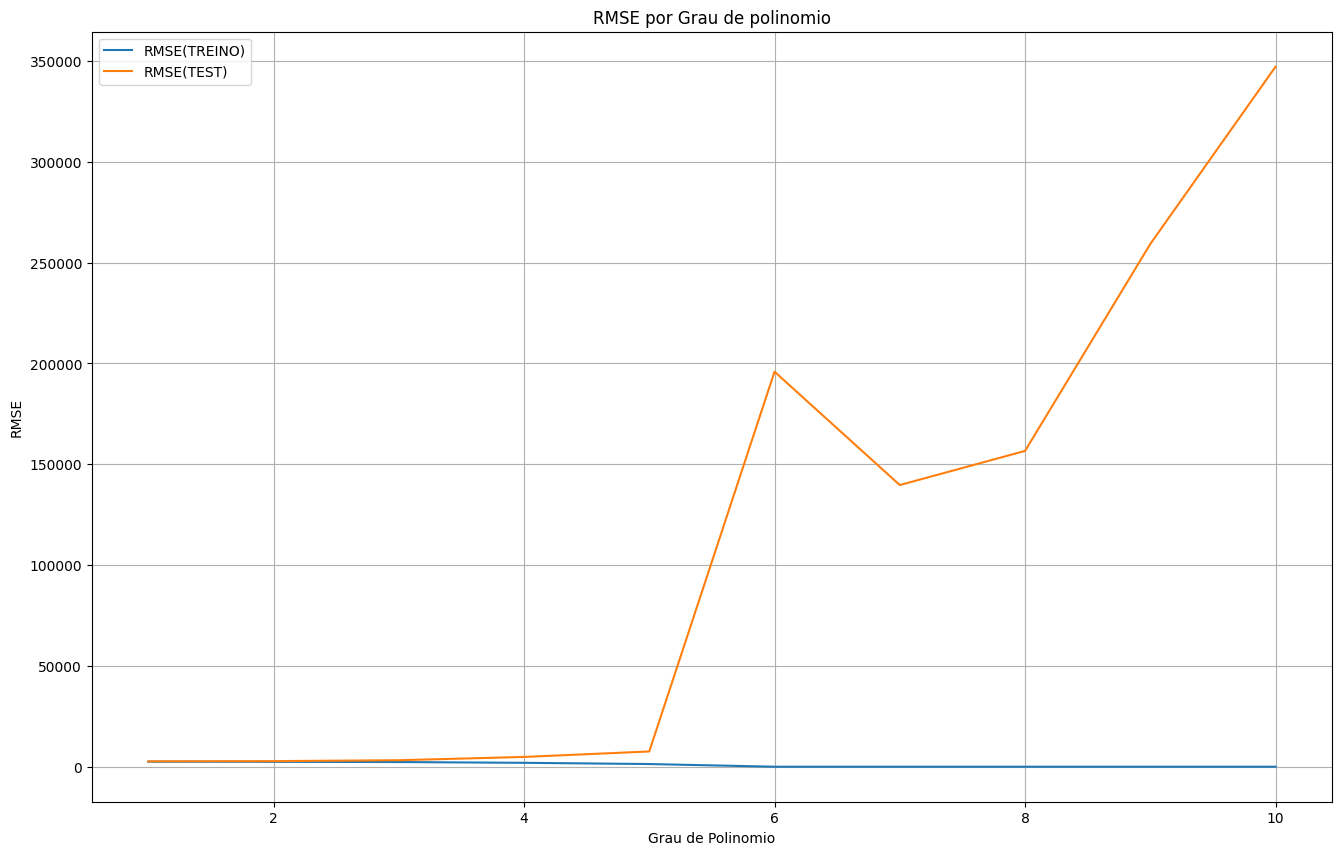

In [76]:
plt.figure(figsize=(16,10))
plt.plot(graus_polynomial, rmse_train_values, label='RMSE(TREINO)')
plt.plot(graus_polynomial, rmse_test_values, label='RMSE(TEST)')
plt.xlabel('Grau de Polinomio')
plt.ylabel('RMSE')
plt.title('RMSE por Grau de polinomio')
plt.grid(True)
plt.legend()
plt.show()

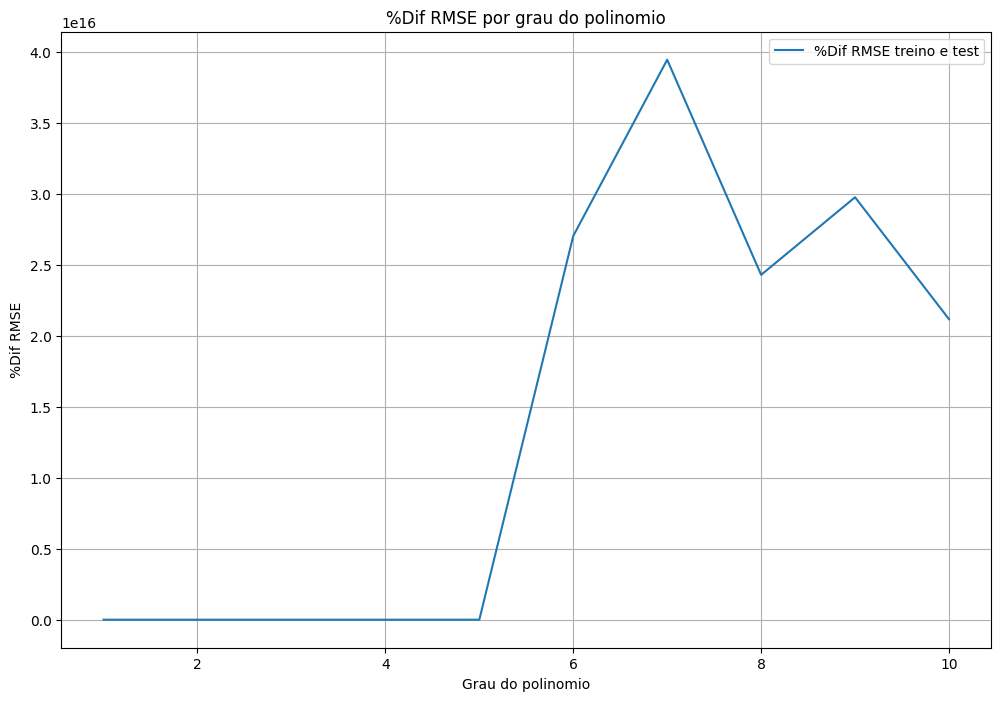

In [77]:
# Plotar grafico para comparar percentual de diferenca de treino e teste rmse
plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, percentual_rmse_values, label='%Dif RMSE treino e test')
plt.xlabel('Grau do polinomio')
plt.ylabel('%Dif RMSE')
plt.title('%Dif RMSE por grau do polinomio')
plt.legend()
plt.grid(True)
plt.show()

Com base na analise do grafico verificamos que o melhor grau é o grau 2, pois a partir do grau 4 vemos um aumento de residuos consideravel entre o conjunto de test e de treino

In [85]:
graus_polynomial = [2]
rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:
    # Colunas numericas

    colunas_numericas = ['tempo_de_experiencia','numero_de_vendas','fator_sazonal']

    # Tranformer numerico
    transformer_numerico = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    #ColumnTranformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', transformer_numerico, colunas_numericas)
    ])
    
    #Features polinomis
    poly_features = PolynomialFeatures(degree=grau, include_bias=False)

    # Modelo Linear
    model_reg_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', poly_features),
        ('regressor', LinearRegression())
    ])

    # Armazenar RMSE Treino e teste
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar R2 score test
    r2score_fold_test = []

    # Amazenar Residuos
    residuos = []

    # Amazenar Predicoes
    y_pred_total = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model_reg_poly.fit(X_train, y_train)
        
        y_train_pred = model_reg_poly.predict(X_train)
        y_test_pred = model_reg_poly.predict(X_test)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        r2score_test = r2_score(y_test, y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)
        
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)
        
    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2score_test_final = np.mean(r2score_fold_test)
    percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
    resisuos = np.array(residuos).reshape(-1)
    
    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2score_test_values.append(r2score_test_final)
    percentual_rmse_values.append(percentual_rmse_final)

In [86]:
print(f'RMSE treino: {rmse_train_final}')
print(f'RMSE teste: {rmse_test_final}')
print(f'% Dif. RMSE Treino e Teste: {percentual_rmse_final}')
print(f'R2score Test: {r2score_test_final}')

RMSE treino: 2423.5170534288945
RMSE teste: 2775.008357109534
% Dif. RMSE Treino e Teste: 14.503355905143497
R2score Test: -0.2466649072431138


Ao comparar as métricas do modelo de regressão linear e o modelo de regressão polinomial, verificasse que o modelo linear é mais apropriado para esse DF, pois apesar de haver uma reducao no RMSE de treino, há um aumento consideravel no RMSE de teste. Isso significa que o modelo polinomial captura padrões que não se repetem nos dados novos, uma vez que os dados das variaveis independentes não são lineares